In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from scipy import signal
import cv2
from scipy.ndimage import convolve


In [22]:
def smooth_image(image, sigma=1):
    # Compute smoothing filter
    r = int(np.ceil(30))
    x = np.arange(-r, r+1, dtype=float)
    g = np.exp(-sigma * np.abs(x)) * (sigma * np.abs(x) + 1)
    g = g / np.sum(g)
    g_d = -x * g
    g_d = g_d / np.sum(np.abs(g_d))

    # Plot smoothing filter
    plt.figure()
    plt.plot(x, g, label='g')
    plt.plot(x, g_d, label='g_d')
    plt.legend()
    plt.title('Smoothing Filter')

    # Apply smoothing filter to image
    g = g.reshape((1, -1))
    g_d = g_d.reshape((1, -1))
    smoothed = convolve(image, g)
    smoothed = convolve(smoothed, g.T)

    return x, g, g_d, smoothed


In [23]:
def edge_detection(g_d, smoothed):
    # Compute gradient magnitude and orientation
    gradient_x = convolve(smoothed, g_d)
    gradient_y = convolve(smoothed, g_d.T)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_orientation = np.arctan2(gradient_y, gradient_x)

    return gradient_magnitude, gradient_orientation


In [24]:
def non_max_suppression(gradient_magnitude, gradient_orientation):
    edges = np.zeros_like(gradient_magnitude)
    for i in range(1, gradient_magnitude.shape[0]-1):
        for j in range(1, gradient_magnitude.shape[1]-1):
            orientation = gradient_orientation[i, j]
            if orientation < 0:
                orientation += np.pi
            orientation = int(orientation / (np.pi / 4))
            if (orientation == 0 and gradient_magnitude[i, j] > gradient_magnitude[i, j-1] and gradient_magnitude[i, j] > gradient_magnitude[i, j+1]) or \
                (orientation == 1 and gradient_magnitude[i, j] > gradient_magnitude[i-1, j+1] and gradient_magnitude[i, j] > gradient_magnitude[i+1, j-1]) or \
                (orientation == 2 and gradient_magnitude[i, j] > gradient_magnitude[i-1, j] and gradient_magnitude[i, j] > gradient_magnitude[i+1, j]) or \
                (orientation == 3 and gradient_magnitude[i, j] > gradient_magnitude[i-1, j-1] and gradient_magnitude[i, j] > gradient_magnitude[i+1, j+1]) or \
                    (orientation == 4 and gradient_magnitude[i, j] > gradient_magnitude[i, j-1] and gradient_magnitude[i, j] > gradient_magnitude[i, j+1]):
                edges[i, j] = gradient_magnitude[i, j]

    return edges


In [25]:
def hysterisis_thresholding(edges, gradient_magnitude, low_threshold, high_threshold):
    low_edges = edges * (edges >= low_threshold)
    high_edges = edges * (edges >= high_threshold)
    for i in range(1, gradient_magnitude.shape[0]-1):
        for j in range(1, gradient_magnitude.shape[1]-1):
            if high_edges[i, j] != 0:
                d = [(1, 0), (1, 1), (0, 1), (-1, 1),
                     (-1, 0), (-1, -1), (0, -1), (1, -1)]
                for di, dj in d:
                    ii, jj = i + di, j + dj
                    if ii >= 0 and ii < gradient_magnitude.shape[0] and jj >= 0 and jj < gradient_magnitude.shape[1]:
                        if low_edges[ii, jj] != 0:
                            high_edges[ii, jj] = gradient_magnitude[ii, jj]

    return high_edges


Text(0.5, 1.0, 'Hysterisis')

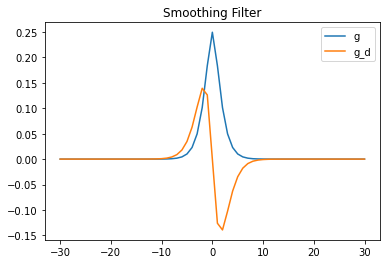

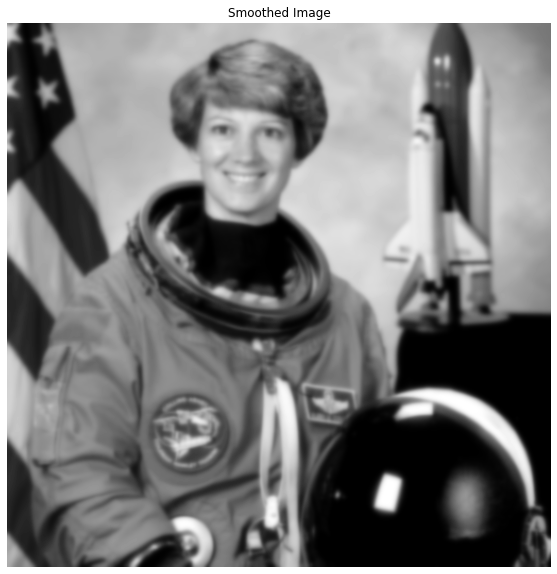

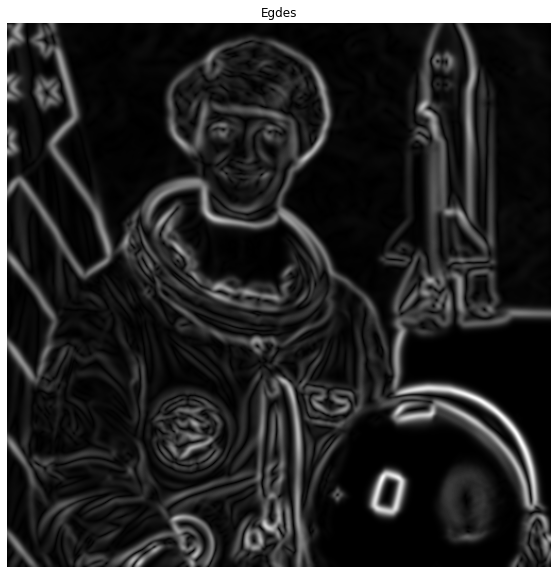

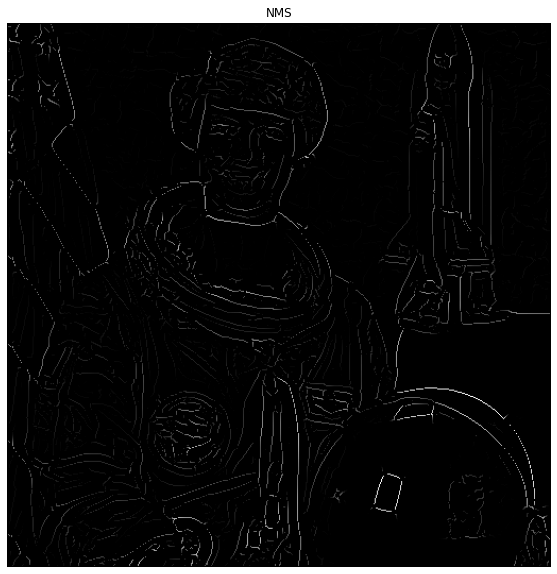

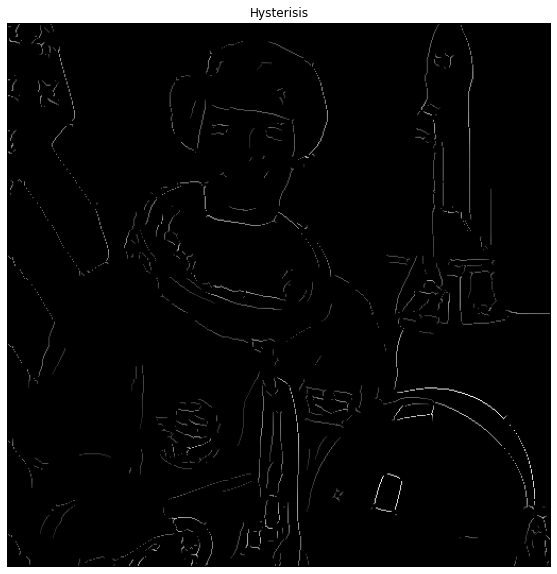

In [26]:
#     """
#     Perform Canny-Deriche edge detection on the input image.

#     Parameters:
#     - image (2D numpy array): Input image.
#     - alpha (float): Decay rate for radial basis function.
#     - sigma (float): Standard deviation for Gaussian smoothing.
#     - low_threshold (float): Lower threshold for edge intensity.
#     - high_threshold (float): Higher threshold for edge intensity.

#     Returns:
#     - edges (2D numpy array): Edge map, with values ranging from 0 to 1.

img = data.astronaut()
img = rgb2gray(img)

x, g, g_d, smoothed = smooth_image(img, sigma=1)

gradient_magnitude, gradient_orientation = edge_detection(g_d, smoothed)

edges = non_max_suppression(gradient_magnitude, gradient_orientation)

high_edges = hysterisis_thresholding(edges, gradient_magnitude,
                                     low_threshold=0.05, high_threshold=0.1)

# Plot smoothed image
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(smoothed, cmap='gray')
plt.title('Smoothed Image')


# plot edges
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Egdes')

# plot result of Non-max-supression
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(edges, cmap='gray')
plt.title('NMS')

# plot final edges after Hysterisis thresholding
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(high_edges, cmap='gray')
plt.title('Hysterisis')


Text(0.5, 1.0, 'Original Image to gray Image')

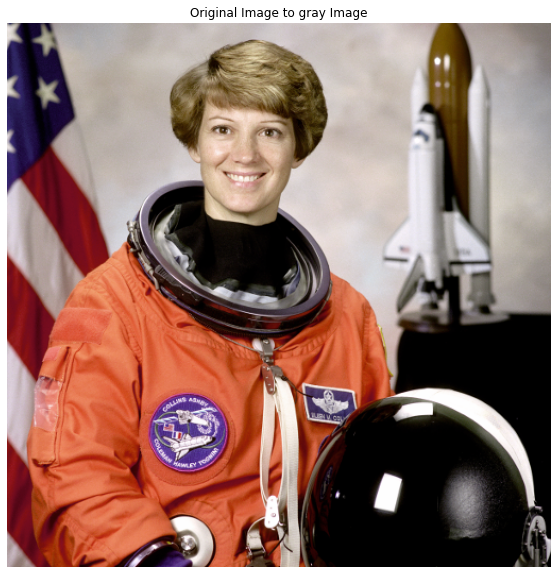